# LabPractice 4.3: Forecasting III

For this practice, you will need the following datasets:
- **ARIMA_II.xlsx**: synthetic dataset with 6 timeseries to practice ARIMA model training.

The main package for time series analysis in Python is **statsmodels**.

Further reading:
- [statsmodels](https://www.statsmodels.org/stable/index.html)

In addition, we will be using the following libraries:
- Data management
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)

- Plotting
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)

- Others
    - MLTools
    - [scipy](https://scipy.org/)

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()

#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf


# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
import scipy as sp

---
## 1. Read the dataset

In [2]:
# Import data
df = pd.read_csv('C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/datos/ARIMA_II.csv',sep=";")
df.head()

,Y1,Y2,Y3,Y4,Y5
0,-0.587047,0.993847,0.983347,0.987,1.022369
1,-1.427480,0.985104,0.950711,0.969,1.071212
2,0.059141,1.000622,0.932761,0.958,1.140348
3,0.653344,1.006893,0.940219,0.999,1.228530
4,-1.788129,0.981376,0.941066,0.952,1.337822


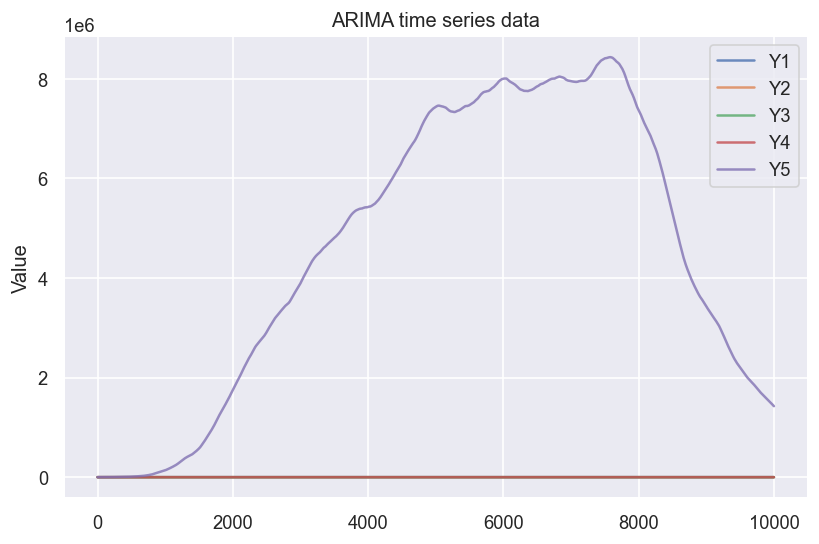

In [3]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='ARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [4]:
df_ts = df[['Y2']] # Maintain data.frame format for column
#df_ts = df_ts[1:4000]
df_ts

,Y2
0,0.993847
1,0.985104
2,1.000622
3,1.006893
4,0.981376
...,...
9995,1.751585
9996,1.739206
9997,1.727996
9998,1.720858


---
### Identification process

#### 1. Plot the series and search for possible outliers

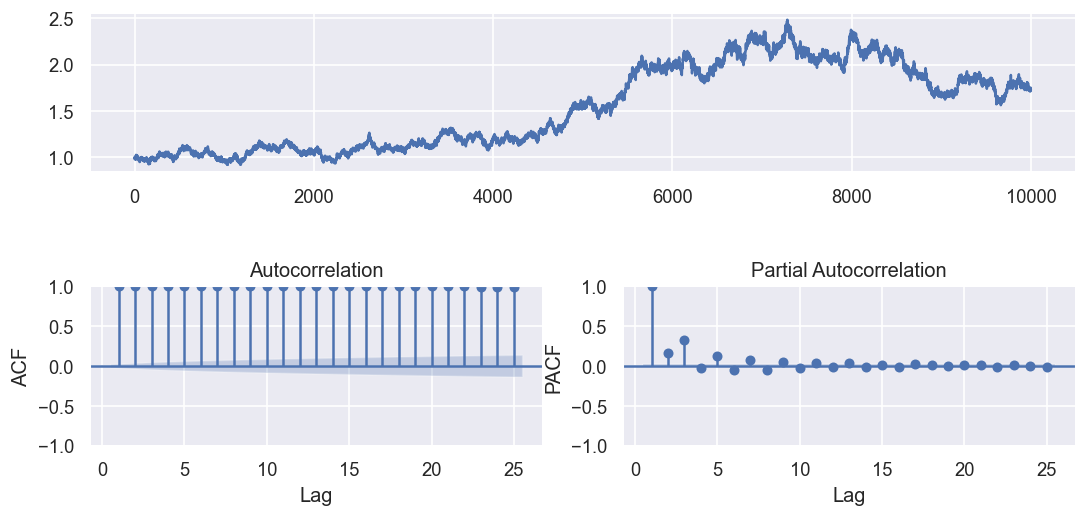

In [5]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts)

#### 2. Stabilize the variance (if needed)

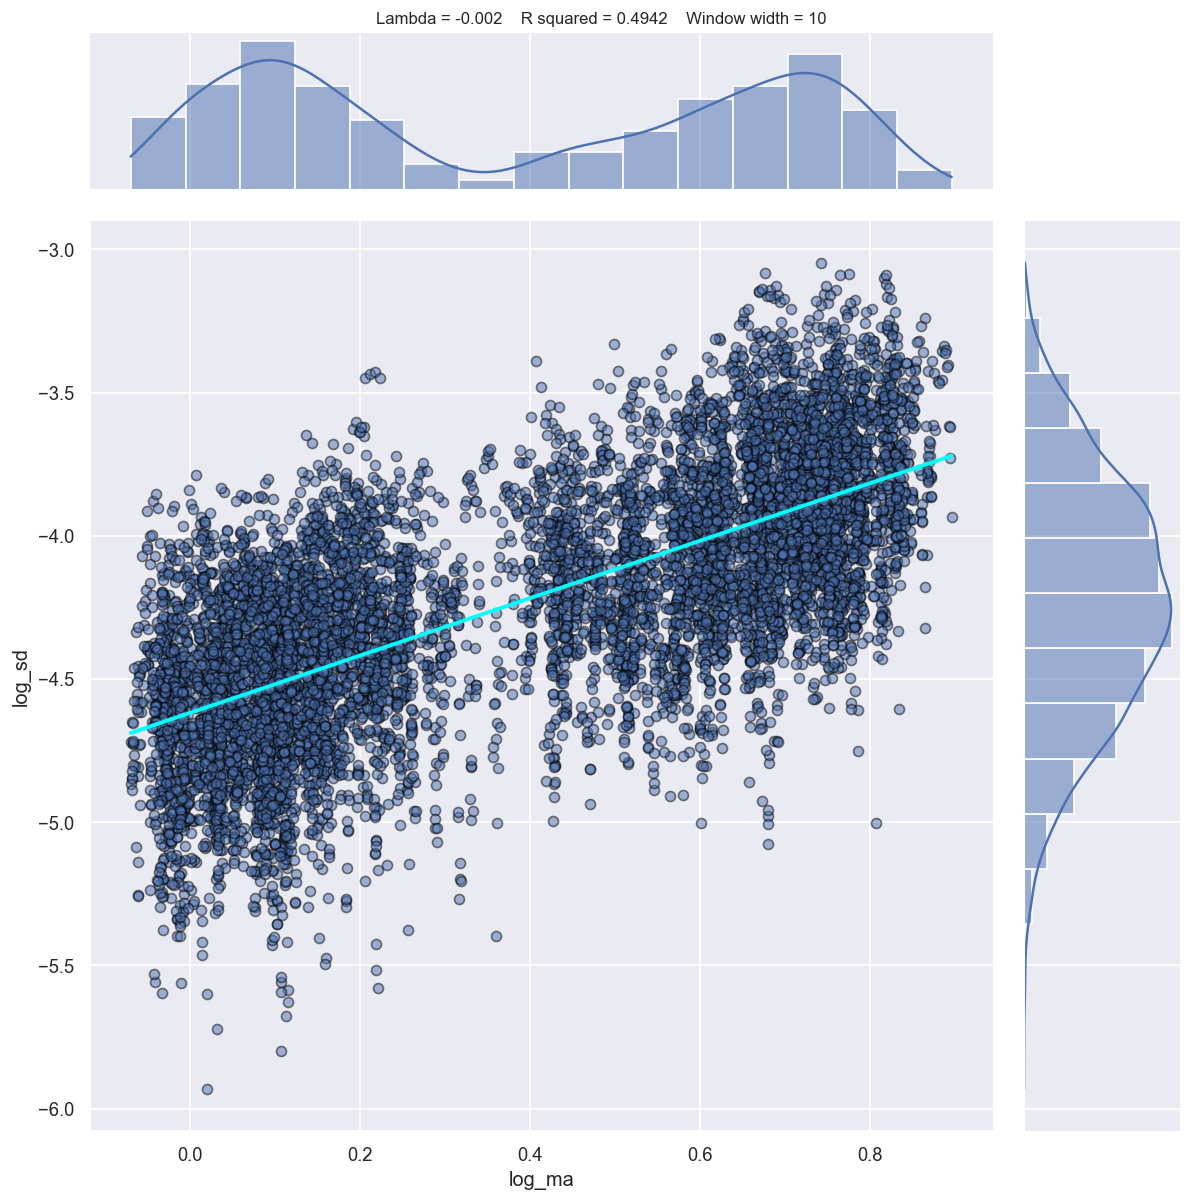

In [6]:
# Box-cox transformation
lmbda = FT.boxcox_lambda_plot(df_ts, window_width=10)

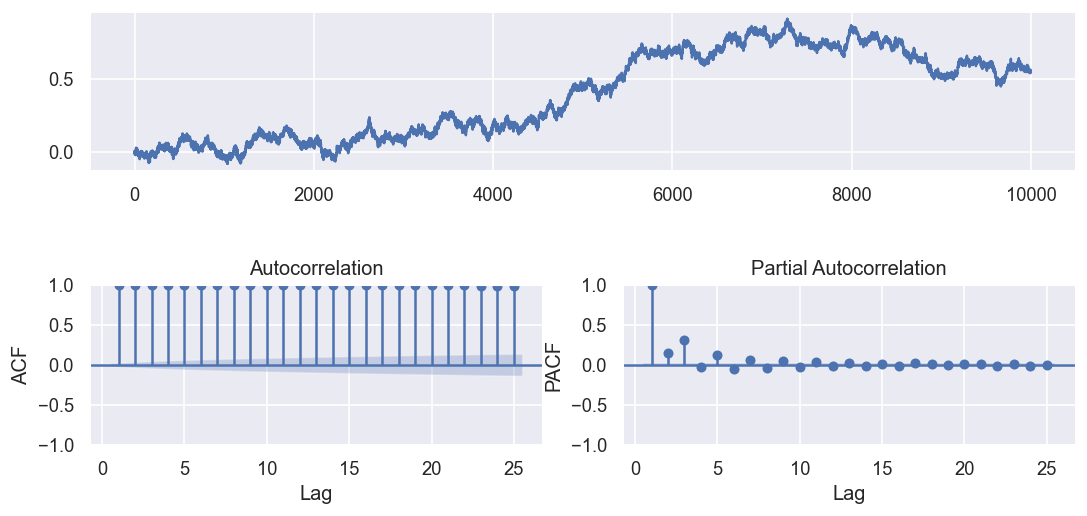

In [7]:
# Compute Box Cox
BOX_COX = True
if BOX_COX:
    lmbda = 0
    z = st.boxcox(df_ts.values[:,0], lmbda = lmbda) #Convert to positive
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
else:
    z = df_ts

FT.ts_display(z)

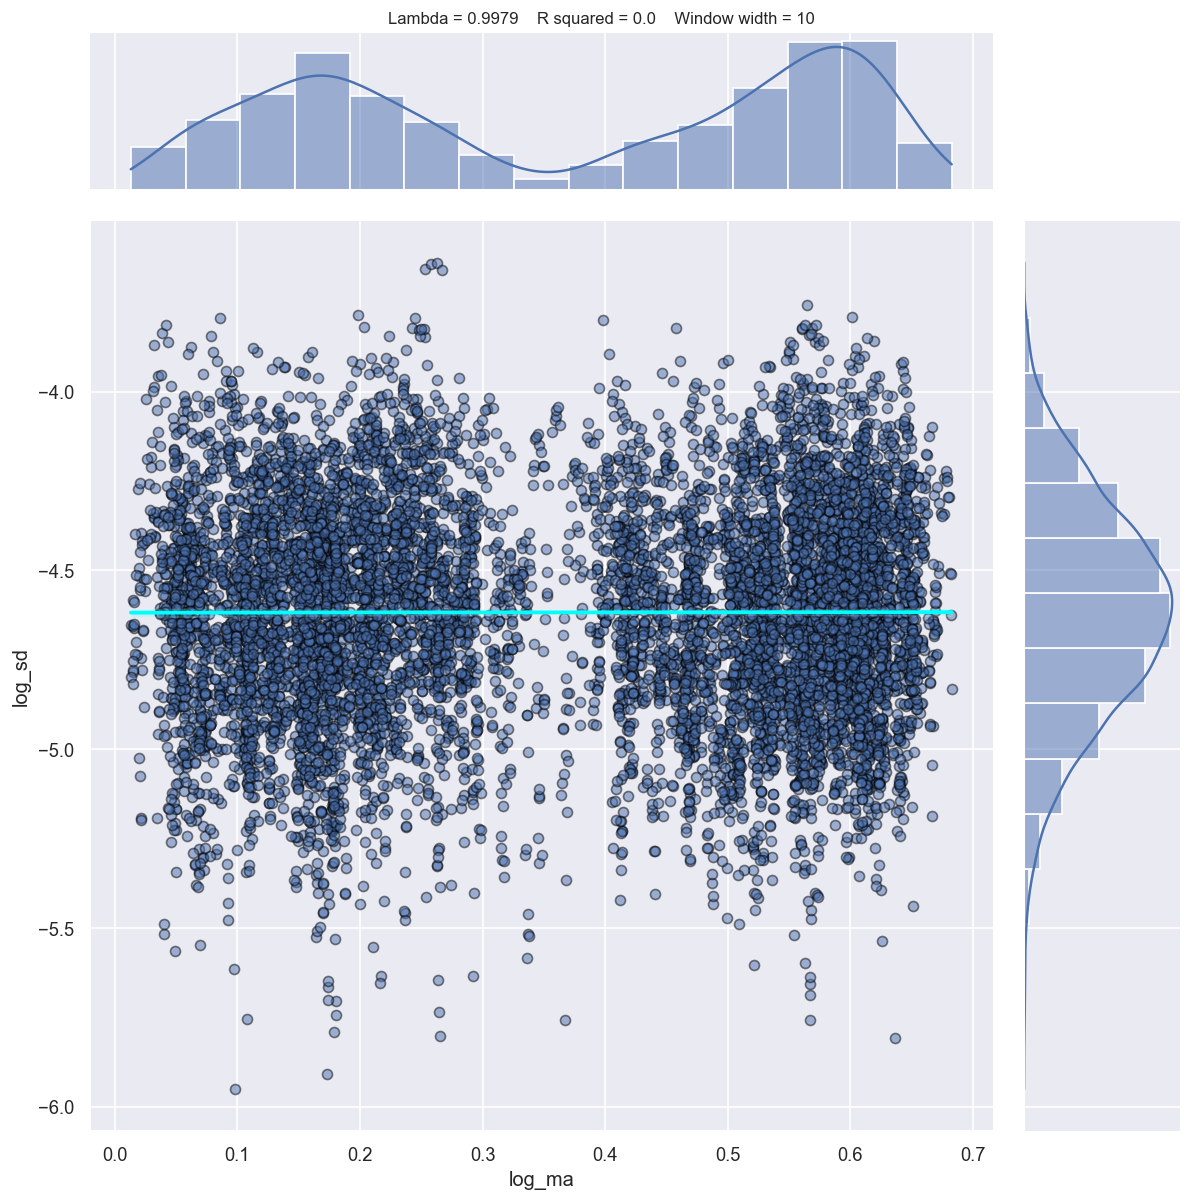

0.9979043965660316

In [8]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=10)

#### 3. Analyze regular differencing

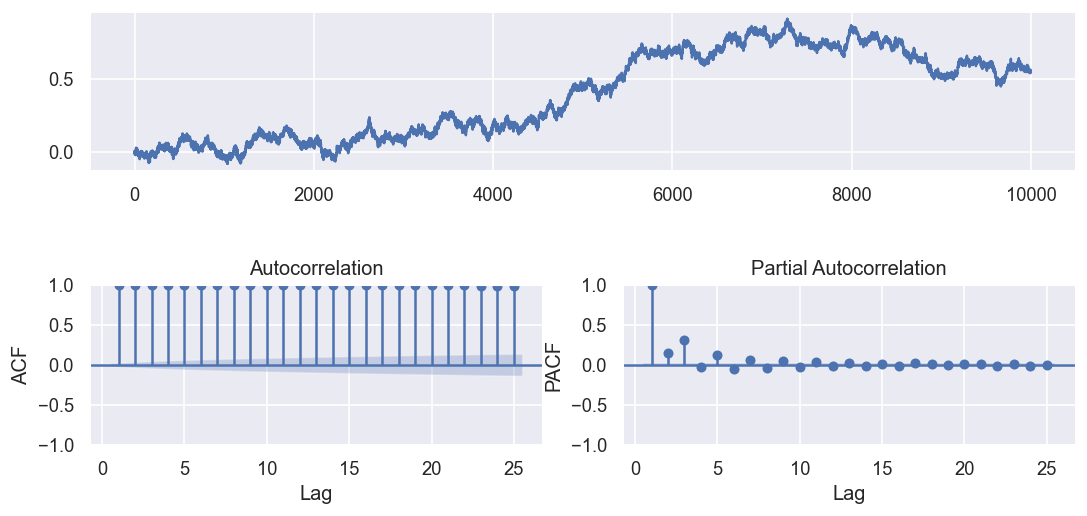

In [9]:
#Graphically
FT.ts_display(z)

In [10]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.285550
p-value: 0.635757
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


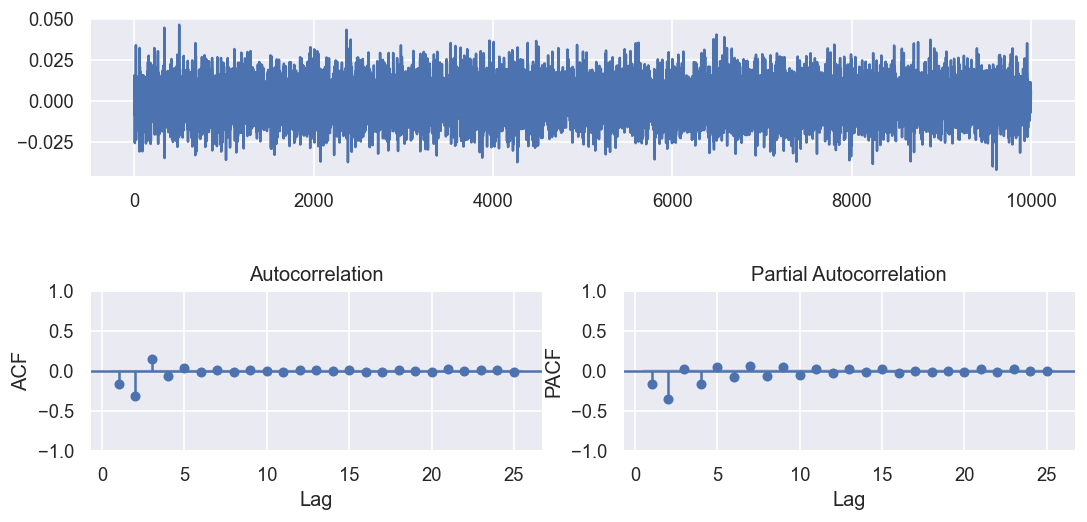

In [11]:
# Difference of the time series
Bz = z.diff().dropna() # drop first NA value
FT.ts_display(Bz)

#### 5. Fit ARIMA model and check significance of the coefficients

In [12]:
# Fit model with estimated order
arima_fit = ARIMA(z, 
                order=(2,1,2),
                trend= 'n' # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                ).fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     Y2   No. Observations:                10000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               31341.730
Date:                Mon, 15 Apr 2024   AIC                         -62673.461
Time:                        21:01:35   BIC                         -62637.409
Sample:                             0   HQIC                        -62661.257
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4638      0.021    -22.061      0.000      -0.505      -0.423
ar.L2         -0.0078      0.021     -0.366      0.715      -0.050       0.034
ma.L1          0.2555      0.019     13.556      0.0

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  38.115515   0.045074


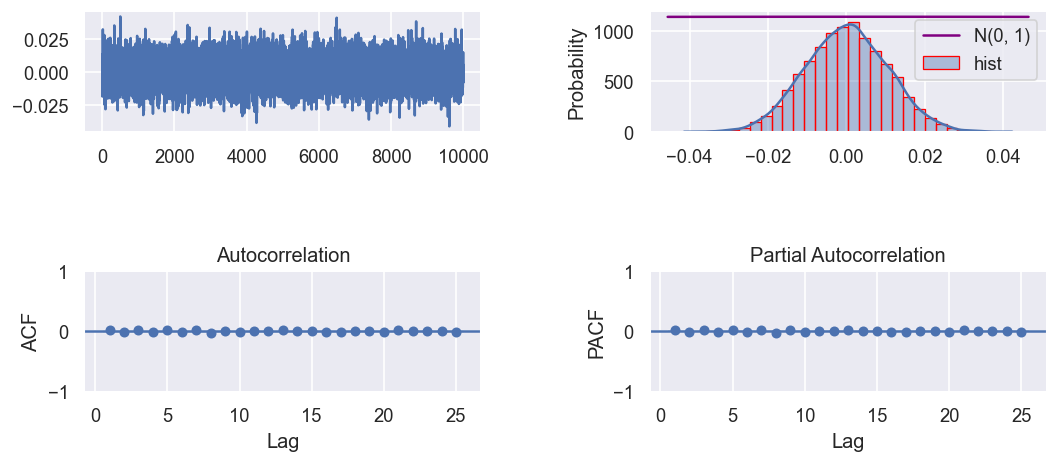

In [13]:
# Plot residual error
FT.check_residuals(pd.DataFrame(arima_fit.resid.loc[3:]))

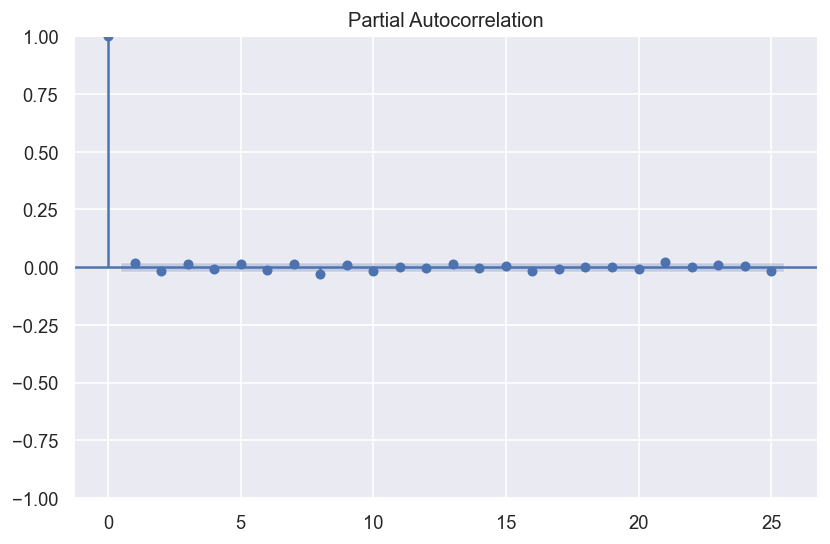

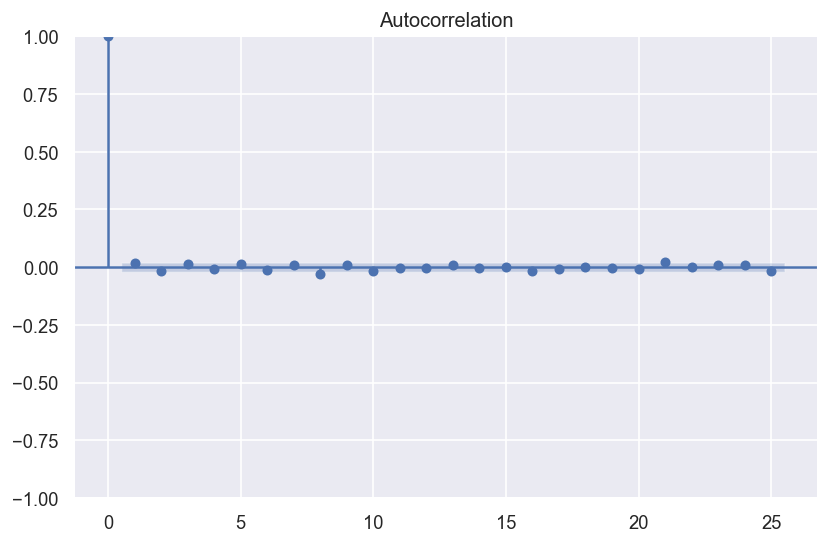

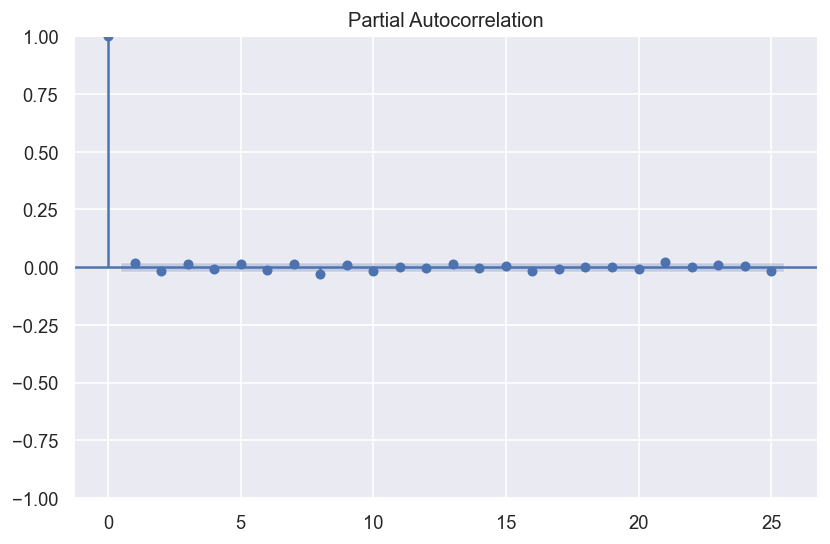

In [14]:
#Bigger plots
plot_acf(arima_fit.resid, lags=25)
plot_pacf(arima_fit.resid, lags=25)

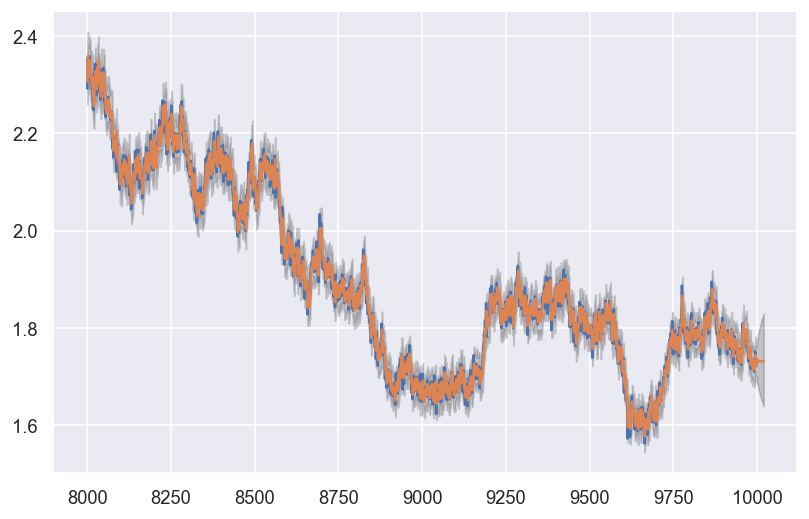

In [15]:
#Obtain forecasts for in-sample and out-of-sample
start = 8000
horizon = 20
end = df_ts.shape[0] + horizon

pred = arima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()